# 1. Introduction
In this project, I will build a classifier to identify Bangla handwritten images. Bangla is the fourth highest spoken language in the world based on the population. There are 10 digits and 50 characters in vowel and consonant in Bangla language where some contains additional sign up and/or below. For this assignment, I have considered 11 vowels of the language to classify. I will build a model that can place an image into one of the 11 class labels. 

To do so, I have implemented Convolutional Neural Networks (CNN) on this dataset. I have included differnt parameters like, dropout, image augmentation, batch normalization to improve the model. To monitor the model's performance I have used keras callback, early stopping and reducing/increasing learning rate techniques. Finally, I have adopted hyper parameter optimization technique to find out the best model for classification. Moreover, a Dense Neural Network (DNN) with hyper parameter optimization technique has been implemented to make a comparison with CNN. The next sections include all these processes as follows: preparing data, building models, inspecting built models, optimization technique, result analysis and final remarks.     

In [1]:
import os, shutil
from skimage import data
from skimage.transform import resize 
import numpy as np
from matplotlib import pyplot
from keras.utils import to_categorical

from keras import layers
from keras import models
import matplotlib.pyplot as plt

from keras import backend as k

k.clear_session()

Using TensorFlow backend.


# 2. Data Analysis
Bangla handwritten dataset has been downloaded from this site [1]. It contains samples of 50 Bangla basic characters, 10 Bangla numerals and 24 selected compound characters. 2000 handwriting samples for each of the 84 characters were collected, digitized and pre-processed. As I am using 11 Bangla vowel character, it includes total 21783 images. I have split this data into 60:20:20 portion for training, validation and testing purpose. That's why, 13200 images are for training, 4289 for testing and rest of the images are for testing. 
## 2.1 Load Dataset
With all these data, I have created three folders: train, test, validation to keep respective dataset.

In [2]:
#load dataset from folder
path, dirs, files = next(os.walk("Dataset/train"))
path, dirs2, files2 = next(os.walk("Dataset/test"))
path, dirs3, files3 = next(os.walk("Dataset/validation"))

## 2.2 Preprocessing Dataset
Data preprocessing aims at making the raw data at hand more amenable to neural networks. Data should be formatted into appropriately pre-processed floating point tensors before being fed into the network. So, I have applied foloowing procedures to prepare dataset.
- **Change Label:** In this dataset, each folder represnets different alphabets. There is 11 folders that starts from 1. Hence, I have changed their label that starting from 0-10. Each of the number represents different character. The class labels are as follow:

![title](img/labels.png)

In [3]:
#read image,change label
def process_data(files,folder):
    label_dict={'1':'0','2':'1','3':'2','4':'3','5':'4','6':'5','7':'6','8':'7','9':'8','10':'9','11':'10'}
    x=[]
    y=[]
    for file in files:
        limg= data.imread("Dataset/"+folder+'/'+file)
        key = file.split('_')[-1].split('.')[0]
        label_name = label_dict[key]
        #img.resize(200,200)
        y.append(label_name)
        x.append(limg)
    return x,y

In [4]:
#read image,change label
rx_train, y_train = process_data(files,'train')
rx_test, y_test = process_data(files2,'test')
rx_val, y_val = process_data(files3,'validation')
print(len(rx_train),'',len(y_train))
print(len(rx_test),'',len(y_test))
print(len(rx_val),'',len(y_val))

13200  13200
4289  4289
4294  4294


The output of following five plots represents first five alphabets from train set. The first character is labeled as class 0, second character is labeled as class 10 and so on. So, other alphabets will have different labels, but similar alphabets will have same labels. 

In [ ]:
#Show first 5 alphabets from train set 
for i in range(0, 5):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(rx_train[i], cmap=pyplot.get_cmap('gray'))
# show the plot
pyplot.show()

- **Reshape Data:** Each image is in grayscale format with different sizes in corresponding dataset. Whereas, Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels) in convolutional model. So, I have converted each image into (34, 34, 1) shape. 

In [5]:
x_train=np.array(rx_train).reshape(len(rx_train),34,34,1)
x_test=np.array(rx_test).reshape(len(rx_test),34,34,1)
x_val=np.array(rx_val).reshape(len(rx_val),34,34,1)

- **Normalize Data:** As actual images are 8 bit integers, I converted theme into floating point tensors.Then, rescale the pixel values (between 0 and 255) to the [0, 1] interval as neural networks prefer to deal with small input values. To represent the label, I am using one-hot-encoding which turn the list of numeric or categorical values into the vectors of 0s and 1s.  


In [6]:
x_train = np.array(x_train).astype('float32') / 255
x_test = np.array(x_test).astype('float32') / 255
x_val = np.array(x_val).astype('float32') / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [7]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(13200, 34, 34, 1)
(4289, 34, 34, 1)
(4294, 34, 34, 1)
(13200, 11)
(4289, 11)
(4294, 11)


# 3. Create Model

The workflow will be as follows: First, training data (train_images and train_labels) will be passed into the neural network. The network will then learn to associate images and labels. Finally, the network will be tested by predicting for test_images, and verified whether these predictions match the labels from test_labels. For this assignment, I have applied following methods to classify my dataset. 
- Convolution Neural Network
- Data Augmentation
- Convolution Neural Network with Dropout and Batch Normalization
- Depthwise Separable Convolution 
- Dense Neural Networks
- Hyperparameter Optimization (DNN)
- Hyperparameter Optimization (CNN)
<p>In later sections, each method is explained along with trainning and testing process. </p>

## 3.1 Convolution Neural Network (CNN)
<p>The CNNs have several different filters consisting of trainable parameters which can convolve on a given image spatially to detect features like edges and shapes. These high number of filters essentially learn to capture spatial features from the image based on the learned weights through back propagation and stacked layers of filters can be used to detect complex spatial shapes from the spatial features at every subsequent level. Convolutions are defined by two key parameters:</p>
 - Size of the patches extracted from the inputs: In this case, it is 3 × 3.

 - Depth of the output feature map: The number of filters computed by the convolution. This model started with a depth of 16 and ended with a depth of 128.

Other parameters for this model are:

* Activation function for each layer is 'relu' and for final layer is 'softmax'
* As it is a multi-label classification problem, I have selected catrgorical_crossentropy for loss function.
* Optimizer = rmsprop

In [8]:
# Build the model
def create_model(option):    
    if(option==1):   #Simple CNN
        model = models.Sequential()
        model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(34, 34, 1)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(32, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.summary()
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(11, activation='softmax'))
        return model
    elif(option==2):  #CNN with dropout
        model = models.Sequential()
        model.add(layers.Conv2D(16, (3, 3), activation='relu',input_shape=(34, 34, 1)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.25))
        model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.25))
        model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.25))
        model.summary()

        model.add(layers.Flatten())
        model.add(layers.Dropout(0.25))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(11, activation='softmax'))
        return model
    elif(option ==3):   #CNN with Batch Normalization
        model = models.Sequential()
        model.add(layers.Conv2D(16, (3, 3), activation='relu',input_shape=(34, 34, 1)))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))       
        model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))       
        model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        model.summary()
    
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(11, activation='softmax'))
        return model
    else:                #CNN with Batch Normalization and Dropout
        model = models.Sequential()
        model.add(layers.Conv2D(16, (3, 3), activation='relu',input_shape=(34, 34, 1)))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.25))
        model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.25))
        model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.25))
        model.summary()


        model.add(layers.Flatten())
        model.add(layers.Dropout(0.25))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(11, activation='softmax'))      
        return model     

### Train Simple CNN Model

In [9]:
def train_model(x_train,y_train,x_val,y_val,model):
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(x_train, 
          y_train, 
          epochs=20,
          batch_size = 10,
          validation_data=(x_val,y_val))
    history_dict = history.history
    return history_dict
    

### Create graph for training and validation accuracy

In [10]:
def create_graph(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss =history['val_loss']
    epochs = range(1, len(acc) + 1)
    print('Position of minimum val_loss: ',np.argmin(val_loss)+1, 'Position of maximum val_acc: ',np.argmax(val_acc)+1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    

### Test the model

In [11]:
def test_model(model,x_test,y_test,step):
    test_loss, test_acc = model.evaluate(x_test, y_test,steps=step)
    print('Test Accuracy: ',test_acc)
    

In [12]:
model = create_model(1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 64)          18496     
Total params: 23,296
Trainable params: 23,296
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = train_model(x_train,y_train,x_val,y_val,model)

Train on 13200 samples, validate on 4294 samples
Epoch 1/20
13200/13200 [==============================] - 40s 3ms/step - loss: 0.6134 - acc: 0.7872 - val_loss: 0.4946 - val_acc: 0.8402
Epoch 2/20
13200/13200 [==============================] - 40s 3ms/step - loss: 0.2615 - acc: 0.9182 - val_loss: 0.4238 - val_acc: 0.8649
Epoch 3/20
13200/13200 [==============================] - 40s 3ms/step - loss: 0.1868 - acc: 0.9430 - val_loss: 0.3946 - val_acc: 0.8707
Epoch 4/20
13200/13200 [==============================] - 41s 3ms/step - loss: 0.1405 - acc: 0.9582 - val_loss: 0.4498 - val_acc: 0.8754
Epoch 5/20
13200/13200 [==============================] - 42s 3ms/step - loss: 0.1125 - acc: 0.9664 - val_loss: 0.3902 - val_acc: 0.8868
Epoch 6/20
13200/13200 [==============================] - 41s 3ms/step - loss: 0.0861 - acc: 0.9754 - val_loss: 0.6250 - val_acc: 0.8619
Epoch 7/20
13200/13200 [==============================] - 40s 3ms/step - loss: 0.0670 - acc: 0.9793 - val_loss: 0.5849 - val_acc:

Position of minimum val_loss:  5 Position of maximum val_acc:  10


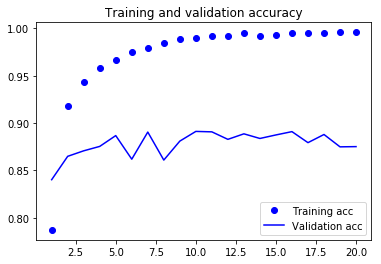

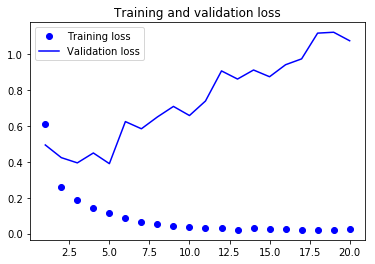

In [14]:
create_graph(history)

In [15]:
#Test Model
test_model(model,x_test,y_test,(np.argmin(history['val_loss'])+1))

5/5 [==============================] - 10s 2s/step
Test Accuracy:  0.9102354645729065


## 3.2 Data Augmentation
In the above model, minimum validation loss is found at position 3. It is quite an indication of overfitting. Overfitting is caused by having too few samples to learn from, unable to train a model that can generalize to new data. Data augmentation is a popular technique to prevent overfiting. It takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, model will never see the exact same picture twice. In following section I have generated train data using ImageDataGenerator function.

<p> Incorporating data augmentation should increase the classification rate. But in this case, it seems doing the opposite as the result is decreasing. The result is presented in the last section of this chapter.</p>

In [16]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.005,
    height_shift_range=0.005,
    shear_range=0.02,
    zoom_range=0.02,
    horizontal_flip=True,
    fill_mode='nearest')

In [17]:
# Build the model
model = create_model(1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 64)          18496     
Total params: 23,296
Trainable params: 23,296
Non-trainable params: 0
_________________________________________________________________


In [18]:
def train_with_augmentation(x_train,y_train,x_val,y_val,model):
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit_generator(
        datagen.flow(x_train,y_train,batch_size=10),
        steps_per_epoch=10,
        epochs=20,
        validation_data=(x_val,y_val),
        validation_steps=10)
    history_dict = history.history
    return history_dict

In [19]:
# Train the model
history = train_with_augmentation(x_train,y_train,x_val,y_val,model)

Epoch 1/20
10/10 [==============================] - 6s 628ms/step - loss: 2.4215 - acc: 0.1000 - val_loss: 2.3735 - val_acc: 0.1511
Epoch 2/20
10/10 [==============================] - 5s 451ms/step - loss: 2.3653 - acc: 0.1500 - val_loss: 2.3219 - val_acc: 0.1369
Epoch 3/20
10/10 [==============================] - 5s 452ms/step - loss: 2.2398 - acc: 0.2300 - val_loss: 2.1438 - val_acc: 0.2205
Epoch 4/20
10/10 [==============================] - 4s 444ms/step - loss: 2.0478 - acc: 0.2700 - val_loss: 2.0677 - val_acc: 0.2625
Epoch 5/20
10/10 [==============================] - 4s 446ms/step - loss: 1.8002 - acc: 0.3900 - val_loss: 1.8567 - val_acc: 0.3374
Epoch 6/20
10/10 [==============================] - 5s 462ms/step - loss: 1.7998 - acc: 0.3300 - val_loss: 1.7937 - val_acc: 0.3395
Epoch 7/20
10/10 [==============================] - 5s 474ms/step - loss: 1.5584 - acc: 0.4600 - val_loss: 1.8389 - val_acc: 0.3663
Epoch 8/20
10/10 [==============================] - 5s 482ms/step - loss: 1.

Position of minimum val_loss:  19 Position of maximum val_acc:  19


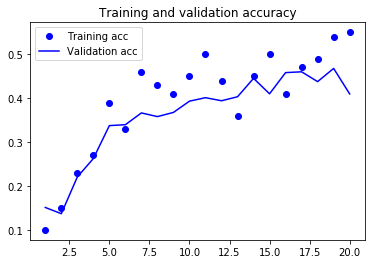

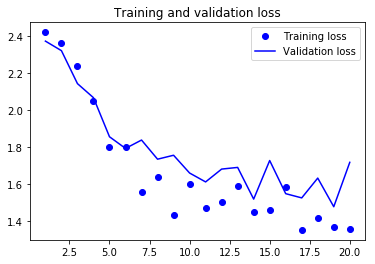

19/19 [==============================] - 36s 2s/step
Test Accuracy:  0.45581719279289246


In [20]:
# Training and Validation Graph
create_graph(history)

# Evaluate the model
test_model(model,x_test,y_test,(np.argmin(history['val_loss'])+1))

## 3.3 Convolution Neural Network with Dropout and Batch Normalization
In this section I have applied multiple parameters in CNN model to maximize the accuracy level. The outcome of these experiments are described later in summary section.
### 3.3.1 CNN with Dropout
Another technique to reduce overfitting is to add dropout layer in the model.

In [21]:
# Build the model
model = create_model(2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 64)          18496     
__________

In [ ]:
# Train the model
#history = train_model(x_train,y_train,x_val,y_val,model)
history = train_with_augmentation(x_train,y_train,x_val,y_val,model)

Epoch 1/20
10/10 [==============================] - 7s 728ms/step - loss: 2.4280 - acc: 0.1200 - val_loss: 2.3763 - val_acc: 0.1521
Epoch 2/20
10/10 [==============================] - 5s 528ms/step - loss: 2.3583 - acc: 0.1800 - val_loss: 2.3565 - val_acc: 0.1530
Epoch 3/20
10/10 [==============================] - 5s 488ms/step - loss: 2.3559 - acc: 0.1700 - val_loss: 2.3270 - val_acc: 0.1688
Epoch 4/20
10/10 [==============================] - 5s 501ms/step - loss: 2.3319 - acc: 0.1600 - val_loss: 2.2666 - val_acc: 0.2694
Epoch 5/20
10/10 [==============================] - 5s 454ms/step - loss: 2.2370 - acc: 0.2600 - val_loss: 2.1933 - val_acc: 0.2483
Epoch 6/20
10/10 [==============================] - 5s 477ms/step - loss: 2.2056 - acc: 0.2100 - val_loss: 2.1006 - val_acc: 0.3114
Epoch 7/20
10/10 [==============================] - 5s 505ms/step - loss: 2.1423 - acc: 0.2400 - val_loss: 2.0003 - val_acc: 0.3309
Epoch 8/20
10/10 [==============================] - 5s 494ms/step - loss: 2.

Position of minimum val_loss:  14 Position of maximum val_acc:  16


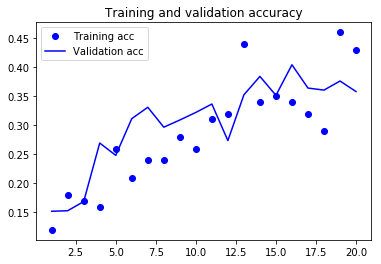

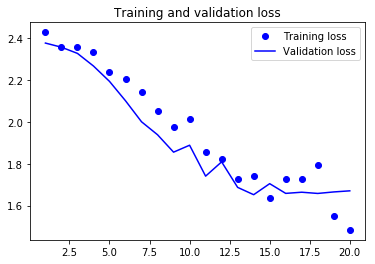

14/14 [==============================] - 32s 2s/step
Test Accuracy:  0.3835392892360687


In [ ]:
# Training and Validation Graph
create_graph(history)

# Evaluate the model
test_model(model,x_test,y_test,(np.argmin(history['val_loss'])+1))

### 3.3.2 CNN with Batch Normalization
Batch normalization is a type of layer (BatchNormalization in Keras) that can adaptively normalize data even as the mean and
variance change over time during training. It works by internally maintaining an exponential moving average of the batch-wise mean and variance of the data seen during training. The main effect of batch normalization is that it helps with gradient propagation and thus allows for deeper networks.

In [ ]:
# Build the model
model = create_model(3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 64)          18496     
__________

In [ ]:
# Train the model
#history = train_model(x_train,y_train,x_val,y_val,model)
history = train_with_augmentation(x_train,y_train,x_val,y_val,model)

Epoch 1/20
10/10 [==============================] - 14s 1s/step - loss: 2.5768 - acc: 0.1900 - val_loss: 3.6327 - val_acc: 0.1882
Epoch 2/20
10/10 [==============================] - 10s 1s/step - loss: 2.1474 - acc: 0.2700 - val_loss: 3.0902 - val_acc: 0.3069
Epoch 3/20
10/10 [==============================] - 10s 995ms/step - loss: 2.0672 - acc: 0.3500 - val_loss: 3.1919 - val_acc: 0.2969
Epoch 4/20
10/10 [==============================] - 10s 994ms/step - loss: 1.6917 - acc: 0.3600 - val_loss: 2.7564 - val_acc: 0.3307
Epoch 5/20
10/10 [==============================] - 10s 1s/step - loss: 1.6699 - acc: 0.4300 - val_loss: 2.4316 - val_acc: 0.3409
Epoch 6/20
10/10 [==============================] - 10s 960ms/step - loss: 1.6466 - acc: 0.4000 - val_loss: 2.3225 - val_acc: 0.3547
Epoch 7/20
10/10 [==============================] - 10s 1s/step - loss: 1.5062 - acc: 0.4500 - val_loss: 2.2874 - val_acc: 0.3759
Epoch 8/20
10/10 [==============================] - 10s 1s/step - loss: 1.4500 - 

Position of minimum val_loss:  20 Position of maximum val_acc:  20


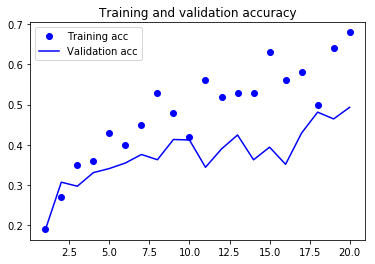

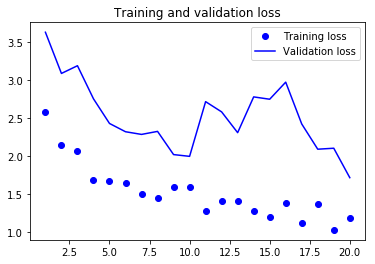

20/20 [==============================] - 164s 8s/step
Test Accuracy:  0.535322904586792


In [ ]:
# Training and Validation Graph
create_graph(history)

# Evaluate the model
test_model(model,x_test,y_test,(np.argmin(history['val_loss'])+1))

### 3.3.3 CNN with Dropout and Batch Normalization
I have combined both dropout and normalization to improve the classification rate. Comparing with other two approaches, it shows the best result so far. That is **93.5% accuracy rate** 

In [ ]:
# Build the model
model = create_model(5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 32)          0         
__________

* After creating the model, I have implemented it on both normal dataset and augmentic dataset. 

In [ ]:
# Train the model

history = train_model(x_train,y_train,x_val,y_val,model)

Train on 13200 samples, validate on 4294 samples
Epoch 1/20
 7540/13200 [================>.............] - ETA: 1:11 - loss: 1.0912 - acc: 0.6159

In [ ]:
# Train model with augmentated data
history = train_with_augmentation(x_train,y_train,x_val,y_val,model)

In [ ]:
# Training and Validation Graph
create_graph(history)

# Evaluate the model
test_model(model,x_test,y_test,(np.argmin(history['val_loss'])+1))

In [ ]:
### Display Predicted Image

## predicted Image
predicted_classes = model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, y_test.shape

import matplotlib.pyplot as plt
correct = np.where(predicted_classes==y_test)[0]
print ("Found correct labels", len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[correct].reshape(34,34), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    plt.tight_layout()

## 3.4 Depthwise Separable Convolution 
Depthwise Separable convolutions consists in performing just the first step in a depthwise spatial convolution (which acts on each input channel separately). It requires significantly fewer parameters and involves fewer computations, thus resulting in smaller, speedier models. And because it’s a more representationally efficient way to perform convolution, it tends to learn
better representations using less data, resulting in better-performing models.

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.SeparableConv2D(32, 3,activation='relu',input_shape=(34, 34, 1,)))
model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.SeparableConv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.SeparableConv2D(128, 3, activation='relu'))
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(11, activation='softmax'))



In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['acc'])
history = model.fit(x_train, 
          y_train, 
          epochs=20,
          batch_size = 10,
          validation_data=(x_val,y_val))

In [ ]:
history_dict = history.history
create_graph(history_dict)

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test,steps=(np.argmin(history_dict['val_loss'])+1))
test_acc

## Summary

After applying all these above methods, it is quite clear that using data augmentation does not improve the accuracy rate. Rather, models without augmentation look good. Using two differnet techniques (dropout and batch normalization), creates the best result. 

| Method 	| Dropout 	| Batch N 	| Epoch 	| Low Val_loss 	| Test Accuracy 	| Validation Accuracy 	|
|:------:	|:-------:	|:-------:	|:-----:	|:------------:	|:-------------:	|:-------------------:	|
|   CNN  	|    n    	|    n    	|   20  	|       3      	|    0.90837    	|        0.8922       	|
|   CNN  	|    y    	|    n    	|   20  	|      13      	|    0.925857   	|        0.9059       	|
|   CNN  	|    n    	|    y    	|   20  	|       3      	|    0.933784   	|        0.9089       	|
|   CNN  	|    y    	|    y    	|   20  	|       3      	|    0.93495    	|        0.9459       	|
|   DSC  	|    -    	|    -    	|   20  	|       9      	|    0.869667   	|        0.8386       	|
                                     
                            
                            *** DSC - Depthwise Seperable Convolution
                            **Result of Different Models without Data Augmentation**
                            
It was anticipiated that, depthwise seperable convolution model would minimize the complexity of basic convolution as well as improve the result. But it yields the worst performance for both augmented data and train/test set.                           
                            

                
| Method 	| Dropout 	| Batch N 	| Epoch 	| Low Val_loss 	| Test Accuracy 	| Validation Accuracy 	|
|:------:	|:-------:	|:-------:	|:-----:	|:------------:	|:-------------:	|:-------------------:	|
|   CNN  	|    n    	|    n    	|   20  	|      18      	|    0.378876   	|        0.381        	|
|   CNN  	|    y    	|    n    	|   20  	|      19      	|    0.314059   	|        0.326        	|
|   CNN  	|    n    	|    y    	|   20  	|       5      	|    0.224528   	|        0.3172       	|
|   CNN  	|    y    	|    y    	|   20  	|      19      	|    0.276055   	|        0.323        	|
|   DSC  	|    -    	|    -    	|   20  	|      14      	|    0.089765   	|        0.0915       	|

                             **Result of Different Models with Data Augmentation**

## 3.6 Dense Neural Networks
I have applied DNN network on this dataset to check whether it improves the result. For this implementation, I have created 3 layers model with 16 hidden units except the output layer. Other then that, optimizer, activation function and loss function all are same in both CNN and DNN model. The **classification rate with this model is about 73%** 


In [ ]:
%run DNN.ipynb

## 3.7 Hyperparameter Optimization (DNN)
Hyperparameter optimization is a powerful technique that is an absolute requirement to get to state-of-the-art models on any task. There are lots of parameter and model architectures to build a single network. It is very time consuming to find a best set of layers, activation function and learning rate manually. In this assignment, I have used Hyperas library to select optimized parameters automatically for best model of DNN. **The whole code is included in another notebook named, DNNoptimizer.ipynb.** The optimized parameters for DNN are:
                         * Batch size = 128
                         * No of layer = 3
                         * First Layer = 1024 hidden unit; Dropout= 0.25; activation = relu
                         * Second Layer = 256 hidden units; Dropout= 0.59 ; activation = relu
                         * Third Layer = 128 hidden units; Dropout = 0.66 ; activation = relu
                         * Output Layer: Activation = softmax
                         * Optimizer = adam
                         * learning rate = 0.001
                         * Epochs = 20
Using this optimized model, **the classification rate went up to 85%.** This indicates that accuracy rate is increased by more than 10% from normal model. 

In [ ]:
%run DNNoptimizer.ipynb

## 3.8 Hyperparameter Optimization (CNN)
Another optimization technique is implemented on CNN model. Although using library makes it easy to find the optimized solution, still it is computationally expensive. It takes more than 5 hours to execute. **The whole code is included in another notebook named, OptimizingCNN.ipynb.**

In [ ]:
%run OptimizingCNN.ipynb

# 4. Inspecting Models Using Keras Callback
* Early Stopping: EarlyStopping callback can use to interrupt training once a target metric being monitored has stopped improving for a fixed number of epochs. This callback is typically used in combination with ModelCheckpoint, which lets continually save the model during training.
* Checkpointing: A good use of checkpointing is to output the model weights each time an improvement is observed during training. Checkpointing is setup to save the network weights only when there is an improvement in classification accuracy on the validation dataset (monitor=’val_acc’ and mode=’max’). The weights are stored in a file that includes the score in the filename.

* ReduceLROnPlateau: You can use this callback to reduce the learning rate when the validation loss has stopped improving. Reducing or increasing the learning rate in case of a loss plateau is an effective strategy to get out of local minima during training.

In [ ]:
import keras.utils
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor='val_acc',
    patience=1,
    ),
    keras.callbacks.ModelCheckpoint(
    filepath='my_model.h5',
    monitor='val_loss',
    save_best_only=True,
    ),
    keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,)
]
#Build Simple CNN
model= create_model(1)

#Train Simple CNN

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
            metrics=['acc'])
model.fit(x_train, y_train, epochs=50,batch_size=32,callbacks=callbacks_list,validation_data=(x_val, y_val),save_best_only=True)


# 5. Conclusion
So far, I have applied CNN and DNN. Between these two methods, CNN works well with dropout and batch normalization technique. But there is some challenges in this assignment that I will work on future. These are:

- Although there exists more than 50 characters in Bangla language, this dataset is relatively small than this. To make a better classifier, it is necessary to upgrade this dataset.
- TensorBoard is a great way to visualize model activity in the browser. Anyone can use it in Keras models via the TensorBoard callback. Using tensorboard in model analysis will be my one of the feature work. 
- There is a number of keras function API to build advance neural network model. In future, I will incorporate it in my model.


# 6. Reference

1. https://data.mendeley.com/datasets/hf6sf8zrkc/2
2. https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python
3. https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-i-hyper-parameter-8129009f131b?fbclid=IwAR1TcWxidpqvCaxAxH6KFZOMQw9PnbOBHjIe71at-jVSedBpyxV052ToSFk
4. https://stackoverflow.com/questions/20186344/ipynb-import-another-ipynb-file
5. https://keras.rstudio.com/reference/layer_depthwise_conv_2d.html
6. https://docgo.net/viewdoc.html?utm_source=dropbox-chollet-pdf